# Using Linear Regression for Anomaly Detection
### By: Peter Tillotson [( Acumed Consulting Ltd )](https://acumedconsulting.com)

The simplest case of linear regression attempts to plot a straight line of best fit through the data.

The equation for a straight line is:  
>    $ y = m \times x + c $

Where:  
> $x$ - value on the horizontal axis   
> $y$ - value in on the verticle axis   
> $m$ - is the gradient, and   
> $c$ - is the crossover ( $y$ value when $x=0$ )    

[[ Duke ]](http://people.duke.edu/~rnau/411diff.htm) - Statistical stationarity: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. 

In this case the statistical properties of the future are the same as those of the past. When using linear regression with arbitrary time series we need to take great care. It turns out that most real life time series are none stationary. 

With that caveat, the following builds a simple model and uses data derived statistics to determine unusual behaviour.            

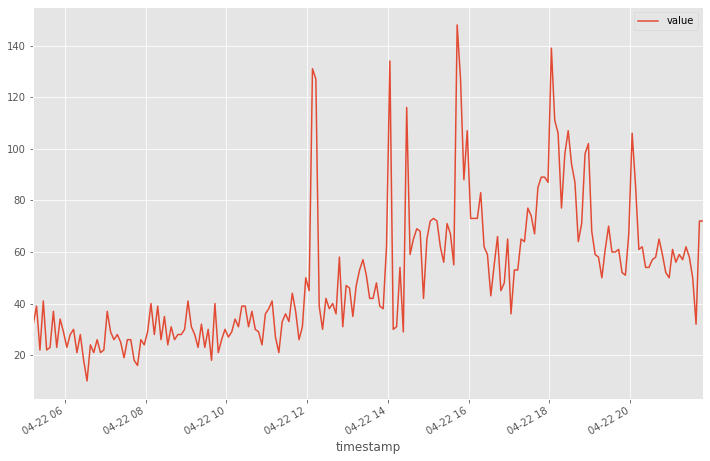

In [4]:
import pandas as pd
import scipy as sp
import numpy as np
pd.options.display.max_rows = 2000

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.style.use('ggplot')

df = pd.read_csv('../data/realTweets/Twitter_volume_GOOG.csv', 
    index_col=0, 
    parse_dates=True
)
df = df.tail(200)
df.plot()

The following uses **SciPy**'s `polyfit` function to calculate the gradient ($m$) and crossover($c$). Then using the 'polyval' function with our calculated $m$ and $c$ for each time index, the $y$ values of the line of best fit are found. 

For the purpose of anomaly detection, if we make a further assumption that the underlying statistics follow an normal distribution then for: 
> $Pr( \mu - \sigma \leq x \leq \mu + \sigma ) \approx 0.6827$   
> $Pr( \mu - 2\sigma \leq x \leq \mu + 2\sigma ) \approx 0.9545$   
> $Pr( \mu - 3\sigma \leq x \leq \mu + 3\sigma ) \approx 0.9973$   

where:
> $\mu$ - mean   
> $\sigma$ - standard deviation   

So: 
> $\approx32\%$ of the data falls outside the bands 1 standard deviation away from the mean.   
> $\approx5\%$ of the data falls outside the bands 2 standard deviation away from the mean.   
> $\approx0.27\%$ of the data falls outside the bands 3 standard deviation away from the mean.   

This is illustrated below by shading the band 2 standard deviations from the mean.

## A note on time series $x$ values

The data set here uses textual dates for it's $x$ value (index).

In [5]:
df.head(5) #show the first 5 records

,value
timestamp,
2015-04-22 05:12:53,32
2015-04-22 05:17:53,39
2015-04-22 05:22:53,22
2015-04-22 05:27:53,41
2015-04-22 05:32:53,22


The functions used below cannot operate on either text or date values, a solution is to convert text to dates then dates to milliseconds since some epoch which can be represented as an 'int'. Alternative approaches would be to define intervals and aggregate in the intervals - say 5 minutes. Keeping the original index, calculate with ints and then plots using dates.

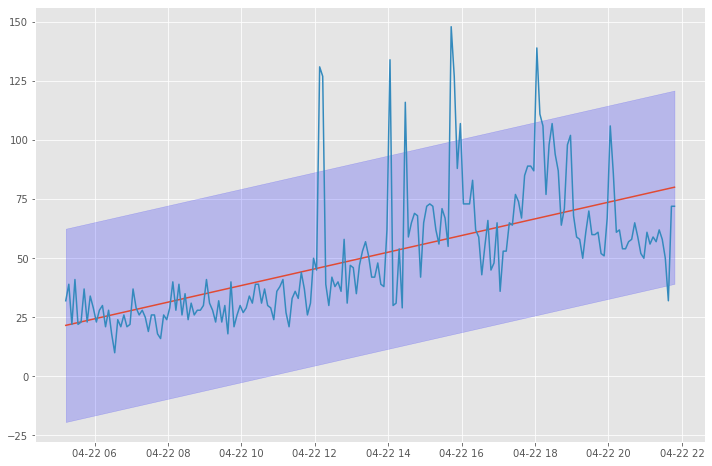

In [6]:
# Have to convert the dates to numeric for the calc
t_idx = pd.to_numeric(df.index)

y = df['value']

# y_fit = m*x+c
(m, c) = sp.polyfit(t_idx, y, 1)
y_fit = sp.polyval([m,c],t_idx)

std = np.std(y-y_fit)

# we can now plot with original index
t_idx = df.index
plt.plot(t_idx, y_fit)
plt.plot(t_idx, y)
plt.fill_between(t_idx, y_fit-2*std, y_fit+2*std, color='b', alpha=0.2)

It is a trivial excercise to identify any value that does not sit within the shaded blue area.

## Curve fitting with higher order polynomial

A straight line is this simplest case, the same aproach can use higher order quadratics, for example:

>  $y = a \times x^2 + b \times x + c$



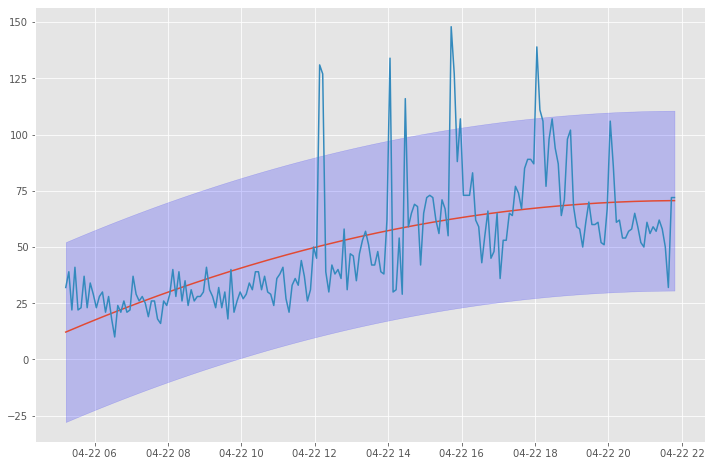

In [7]:
t_idx = pd.to_numeric(df.index)
(a, b, c) = sp.polyfit(t_idx, y, 2)
y_fit = sp.polyval([a,b,c],t_idx)

std = np.std(y-y_fit)

# we can now plot with original index
t_idx = df.index
plt.plot(t_idx, y_fit)
plt.plot(t_idx, y)
plt.fill_between(t_idx, y_fit-2*std, y_fit+2*std, color='b', alpha=0.2)

# Using a Rolling Mean and Standard Deviation for Anomaly Detection

Perhaps a better approach is to just look at the rolling mean and standard deviation over a short historic window. As you can see, because mean and standard deviation are functions of recent history, they follow the trends more closely. This approach is not as susceptable to the problems relating to non stationary data but note how the standard deviation bands get wider when the raw signal is more variable. 

> In Rolling Mean approaches, the mean lags the signal by the length of the window and   
> recent signal volatility takes time to dissipate. 

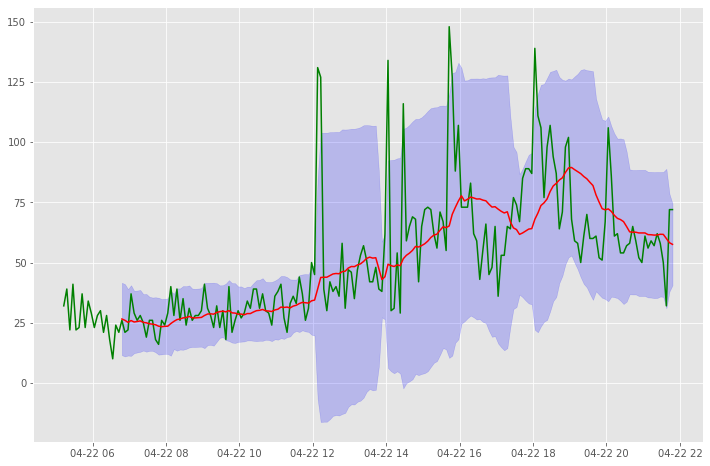

In [8]:
# rolling window of last n samples
r_win = 20
v_mean = df['value'].rolling(r_win).mean()
v_std = df['value'].rolling(r_win).std()

plt.figure()
plt.plot(df.index, df['value'], color='g')
plt.plot(df.index, v_mean, color='r')
plt.fill_between(df.index, v_mean-2*v_std, v_mean+2*v_std, color='b', alpha=0.2)

Wouldn't it be good if the model could predict rather than follow trends. 

---
&copy; Acumed Consulting Ltd. all rights reserved